## Compute average weights used for simulation


In [23]:
curdir = pwd()
dir_one_up = abspath(joinpath(curdir, ".."))

"/Users/mmtre/Library/CloudStorage/OneDrive-IllinoisInstituteofTechnology/Github repos/Celegans_premotor/"

In [24]:
# using DifferentialEquations
using Statistics

# using LinearAlgebra
# using DifferentialEquations, Plots
# using SparseArrays

using JSON
# using LinearAlgebra
using SavitzkyGolay
using Plots
using LaTeXStrings

using StatsPlots

# using DataInterpolations

# using SciMLBase
# using OrdinaryDiffEq

In [25]:
#################################
#### load saved functions  ######
#################################

filename = "functions_regression.jl"
data_folder = "functions"
filepath = joinpath(joinpath(dir_one_up, data_folder), filename);
include(filepath)

#include("functions/functions_regression.jl")
######### contains functions .. #########
## RELU
## Data_Replacement

Data_Replacement (generic function with 1 method)

## load processed White graph data

In [26]:
using DataFrames
using CSV

######################################################
###  load graph saved in White_graph_process  ########
######################################################
data_folder = "data/White_data_processed"
filename = "df5.csv"
filepath = joinpath(joinpath(dir_one_up, data_folder), filename);
df5 = DataFrame(CSV.File(filepath));

############################################
### take processed data from White #########
############################################

out_set = collect(Set(df5[!, :"Neuron2"]))
in_set = collect(Set(df5[!, :"Neuron1"]))
final_neurons = union(out_set, in_set)
N = size(final_neurons)[1]  ## number of neurons in my model
final_neuron_dict = Dict(zip(final_neurons, collect(1:N)))

#############################
### make EJ matrix ##########
#############################
df_EJ = filter(row -> row."Type" == "EJ",df5) # df_subset
EJ_mat = zeros(N,N)
for i in collect(1:size(df_EJ,1))
    w_tmp = df_EJ[i,:]["Nbr"]
    neuro1 = df_EJ[i,:]["Neuron1"]
    neuro2 = df_EJ[i,:]["Neuron2"]
    id1 = final_neuron_dict[neuro1]
    id2 = final_neuron_dict[neuro2]
    EJ_mat[id1, id2] = w_tmp
end

#############################
### make Syn matrix #########
#############################
df_S = filter(row -> row."Type" == "S",df5) # df_subset
S_mat = zeros(N,N)

for i in collect(1:size(df_S,1))
    w_tmp = df_S[i,:]["Nbr"]
    neuro1 = df_S[i,:]["Neuron1"]
    neuro2 = df_S[i,:]["Neuron2"]
    id1 = final_neuron_dict[neuro1]
    id2 = final_neuron_dict[neuro2]
    S_mat[id1, id2] = w_tmp
end

S_mat = S_mat'; # transpose for matrix multiplication
S_mat_bool = S_mat .!=0;

# Load new C. elegans data

# Get intrinsic dynamics via distributions

Bookmark synaptic weights <a name='intrinsic_dynamics' />

In [27]:

data_folder = "data/Atanas_data"
filename = "2023-01-23-15.json"  # avb (use for test?)

filepath1 = joinpath(joinpath(dir_one_up, data_folder), filename);
Fdata1 = JSON.parsefile(filepath1)
labs = Fdata1["labeled"]
Fts1 = Fdata1["trace_array"]
dt = round(Fdata1["avg_timestep"]; digits = 3)

key_set = keys(labs)
Dict_nms = Dict{String,Int}()
for ky in key_set
    Dict_nms[labs[ky]["label"]] = parse(Int64, ky)       
end
names_have = keys(Dict_nms);
ts_len = size(Fts1[1])[1]

ts_myneuros = zeros(N,ts_len)
i = 1 # counter
for nm in final_neurons
    if nm in(names_have)
        ts_myneuros[i,:] = Fts1[Dict_nms[nm]]       
    end
    i+=1 
end

D = copy(ts_myneuros)  # timeseries
row_sum = sum(D, dims = 2)
idxfull_list = Int64[]
for i in collect(1:size(row_sum)[1])
    if row_sum[i] != 0
        append!(idxfull_list, i)
    end  
end

Dshort = D[idxfull_list,:]

distribution_list = ["AVBL","AVBR","RIBL","RIBR","AVDL","AVDR","AVAL","AVAR","RIML","RIMR","AVEL","AVER","AIBL","AIBR"] 

Ndist = size(distribution_list)[1]
ids_dist = []
for i in collect(1:Ndist)
    append!(ids_dist, final_neuron_dict[distribution_list[i]])
end

intersect!(ids_dist, idxfull_list); # get ids of distribution list that we have ts for

## fig - distribution

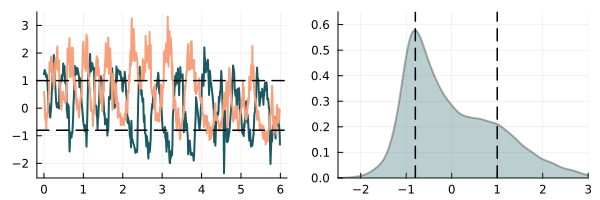

In [28]:
clrsp = palette(:batlow10)
clrs = [clrsp[3], clrsp[8]]

t = dt*collect(0:ts_len-1)

p1 = plot(t[1:600],D[ids_dist[1],1:600], labels = false, color=clrs[1])
p1 = plot!(t[1:600],D[ids_dist[11],1:600], labels = false, color=clrs[2])
p1 = hline!([-0.8, 1], line=:dash, label = false, linewidth = 1.5, color = "black")

p2 = density(reshape(D[ids_dist,:],(:)), linewidth = 2, fill=(0, clrs[1]), alpha=0.3, xlim =(-2.5,3), ylim =(0,0.65), label = false, color = "black")
p2 = vline!([-0.8, 1], line=:dash, label = false, linewidth = 1.5, color = "black")

pall = plot(p1,p2,layout = (1,2), size = (600,200))
display(pall)

# savefig(pall,"figures/intrinsic_dynamics/intrinsic_dyn2.pdf") # avb plot

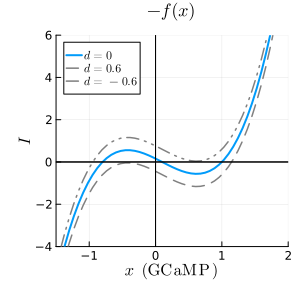

In [29]:
#########################################
## create intrinsic dynamics function ###
#########################################
fp1 = -0.8
fp2 = 0.1
fp3 = 1
f(x) = 2*(x-fp1)*(x-fp2)*(x-fp3)
V(x) = 20*x-70

X(v) = (v+70)*(1/25)
f2(v) = -1*(-1/8000)*((v+70)*(v+60)*(v+50))
pts = Vector([[-120,-70,-60,-50,-20,0,20,40],[-30,0,0,0,20,30,60,140]]) # (V,I) pairs from RMD


default(
    linewidth=2,  
    label=nothing, 
    titlefontsize = 12
)

#pyplot(xlabelfontsize = 10)

x = range(-3, 4, length=100)
v = range(-120, 50, length=300)

p1 = plot(v, f2.(v), ylim = (-60, 160), title = L"-f(V)",xlabel = L"V", ylabel = L"I", label=L"-f(V)")  #ylim = (-40, 160)
p1 = hline!([0 0], label = false, color ="black",linewidth = 1)
p1 = vline!([0 0], label = false, color ="black",linewidth = 1)
p1 = scatter!(pts[1,:],pts[2,:], label = "voltage clamp")

p2 = plot(v,X.(v), label =false, xlabel = L"V", ylabel = L"x \textrm{ \ \ (GCaMP)}", title = L"x(V)")
p2 = hline!([0 0], label = false, color ="black",linewidth = 1)
p2 = vline!([0 0], label = false, color ="black",linewidth = 1)



p3 = plot(x,f.(x), xlim=(-1.5,2), ylim=(-4,6), xticks = -2:1:2, yticks = -4:2:6, title = L"-f(x)",xlabel = L"x \textrm{ \ \ (GCaMP)}", 
    ylabel = L"I", label = L"d = 0")
p3 = plot!(x,f.(x).+0.6, color = :grey, linestyle=:dashdotdot, linewidth = 1.5, label = L"d = 0.6")
p3 = plot!(x,f.(x).-0.6, color = :grey, linestyle=:dash, linewidth = 1.5, label = L"d = -0.6")

p3 = hline!([0 0], label = false, color ="black",linewidth = 1)
p3 = vline!([0 0], label = false, color ="black",linewidth = 1)

# pall = plot(p1, p2, p3, layout = (1,3),size = (900,300))  #size = (900,300)
# savefig(pall,"figures/intrinsic_dynamics/intrinsic_dyn1.pdf") # avb plot

#pall = plot(p1, size = (300,300))
#display(pall)
#savefig(pall,"figures/intrinsic_dynamics/intrinsic_dyn_fv.pdf") # avb plot

pall = plot(p3, size = (300,300))
display(pall)
# savefig(pall,"figures/intrinsic_dynamics/intrinsic_dyn_fx.pdf") # avb plot




# Simulate core neurons using regression weights from whole regression

# average sign across 30 datasets

### make switchout list (sub in L/R pair for highly correlated)

In [30]:
#############################
####  Flavell data ##########
#############################
data_folder = "data/Atanas_data"

fn1 = "2023-03-07-01.json"
fn2 = "2023-01-23-21.json"
fn3 = "2023-01-23-15.json"  # avb (use for test?)
fn4 = "2023-01-19-22.json"
fn5 = "2023-01-19-15.json" # avb
fn6 = "2023-01-19-08.json" # avb
fn7 = "2023-01-19-01.json" # avb
fn8 = "2023-01-17-14.json"
fn9 = "2023-01-17-07.json"
fn10 = "2023-01-16-22.json" #avb, heat
fn11 = "2023-01-16-15.json"
fn12 = "2023-01-16-08.json" #avb, heat
fn13 = "2023-01-10-14.json" #avb, heat  (use this for plot example!)
fn14= "2023-01-10-07.json"  #avb, heat
fn15 = "2023-01-09-28.json"
fn16 = "2023-01-09-22.json"
fn17 = "2023-01-09-15.json"
fn18 = "2023-01-09-08.json" #avb, heat
fn19 = "2023-01-06-15.json"
fn20 = "2023-01-06-08.json"
fn21 = "2023-01-06-01.json"
fn22 = "2023-01-05-18.json" #avb, heat
fn23 = "2023-01-05-01.json"
fn24 = "2022-12-21-06.json"
fn25 = "2022-08-02-01.json"
fn26 = "2022-07-20-01.json"
fn27 = "2022-06-28-07.json"
fn28= "2022-06-28-01.json"
fn29 = "2022-06-14-13.json"
fn30 = "2022-06-14-07.json"

all_filenames = [fn1, fn2, fn3, # skip fn3
     fn4, fn5, fn6, fn7, fn8, fn9, fn10,
                fn11, fn12, fn13,  
    fn14, fn15, fn16, fn17, fn18, fn19, fn20,
                fn21, fn22, fn23, fn24, fn25, fn26, fn27, fn28, fn29, fn30]

num_files = size(all_filenames)[1]

cor_store = zeros(N, num_files)
fname_counter = 1

for fname in all_filenames
    filepath1 = joinpath(joinpath(dir_one_up, data_folder), fname);
    Fdata1 = JSON.parsefile(filepath1)
    labs = Fdata1["labeled"]
    Fts1 = Fdata1["trace_array"]
    key_set = keys(labs)
    Dict_nms = Dict{String,Int}()
    for ky in key_set
        Dict_nms[labs[ky]["label"]] = parse(Int64, ky)       
    end
    names_have = keys(Dict_nms);
    
    i = 1 # counter
    for nm in final_neurons
        ## get two L/R ts to compare ##
        if nm in(names_have)
            ts_tmp1 = Fts1[Dict_nms[nm]]  
            ###### normal length 4 neurons #######
            if length(nm) == 4
                nm_new = [] # put new name in
                if string(nm[4]) == "L"
                    nm_new = string(nm[1:3])*string("R")
                elseif string(nm[4]) == "R"
                    nm_new = string(nm[1:3])*string("L")
                end
                if nm_new in(names_have)
                    #println(nm_new)
                    ts_tmp2 = Fts1[Dict_nms[nm_new]]
                    cor_tmp = cor(ts_tmp1, ts_tmp2) ## compute corelation between two timeseries
                    cor_store[i,fname_counter] = cor_tmp ## put correlation in storage
                end
            end
            ###### end length 4 neurons #######
            ###### length 5 neurons #######
            if length(nm) == 5
                nm_new = [] # put new name in
                if string(nm[5]) == "L"
                    nm_new = string(nm[1:4])*string("R")
                elseif string(nm[5]) == "R"
                    nm_new = string(nm[1:4])*string("L")
                end
                if nm_new in(names_have)
                    #println(nm_new)
                    ts_tmp2 = Fts1[Dict_nms[nm_new]]
                    cor_tmp = cor(ts_tmp1, ts_tmp2) ## compute corelation between two timeseries
                    cor_store[i,fname_counter] = cor_tmp ## put correlation in storage
                end
            end
            ###### end length 5 neurons #######
        end
        i+=1 
    end
    fname_counter+=1
end

cor_mean_list = zeros(N)
for i in collect(1:N)
    tmp_row = cor_store[i,:]
    if sum(tmp_row) !=0
        idx_tmp = findall(tmp_row.!=0)
        cor_vals_tmp = tmp_row[idx_tmp]
        cor_mean_list[i]=mean(cor_vals_tmp)
    end
end

###############################################
## final list of highly correlated neurons ####
###############################################
highly_correlated_neurons = final_neurons[findall(cor_mean_list.>0.7)]; # 75

In [31]:
############################################################
# Get signs between these neurons across 10 datasets #######
############################################################

switchout_list = append!(["AVBL", "AVBR"], highly_correlated_neurons)

########################################################################
##  22 datasets that have at least one of AVBL, AVBR, RIBL, RIBR  ######
########################################################################
## skip files 1, 8, 9, 15, 21, 24, 27, 28
all_filenames = [fn2, fn3, fn4, fn5, fn6, fn7, fn10, fn11, fn12, fn13,  
    fn14, fn16, fn17, fn18, fn19, fn20,
                fn22, fn23, fn25, fn26, fn29, fn30]

num_files = size(all_filenames)[1]

A_10takes = zeros(N,N, num_files)
d_10takes = zeros(N,num_files)
 
#beta_vec = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]  # [12]
beta_vec = [10]  # [12] # try the regression with small EJ!
num_beta = size(beta_vec)[1]

######################
## location of fps ###
######################
## fps at 0, 0.4, 0.8
fp1 = -0.8
fp2 = 0.1
fp3 = 1.0

a = -2
######################
######################

## fill one col at a time, for each dataset go through all betas
error_mat = zeros(num_beta, num_files)  # each row is a different beta value, 30 datasets
error_dxdt_mat = zeros(num_beta, num_files)

cluster_num = 1
error_mat_counter = 1

#########################
## get example error ####
#########################
dxdt_beta_approx_AVAL = 0
dxdt_beta_AVAL = 0
dxdt_approx_AVAL = 0
dxdt_AVAL = 0

dxdt_beta_approx_AVBL = 0
dxdt_beta_AVBL = 0
dxdt_approx_AVBL = 0
dxdt_AVBL = 0

for fname in all_filenames
for beta in beta_vec
        
    ############################################
    #### Regression with edge constraints ######
    ############################################
    coeffs_list = zeros(N,N+1) #  zeros(N,N+4)   # nonlin, d_i, A_ij
    ## fps determined out of the loop
    beta = beta
    ############################################
    ############################################
    filepath1 = joinpath(joinpath(dir_one_up, data_folder), fname);
    Fdata1 = JSON.parsefile(filepath1)
    labs = Fdata1["labeled"]
    Fts1 = Fdata1["trace_array"]
    dt = round(Fdata1["avg_timestep"]; digits = 3)
    dFts1dt = copy(0*Fts1)
    #########################
    #######  smooth data ####
    #########################
    for i in collect(1:size(Fts1)[1])
        ts_tmp = savitzky_golay(Fts1[i], 11, 5).y;
        #ts_tmp = savitzky_golay(Fts1[i], 21, 7).y;
        ts_tmp_chop1 = ts_tmp[3:end]
        ts_tmp_chop2 = ts_tmp[1:end-2]
        dts_dt_tmp = (ts_tmp_chop1 - ts_tmp_chop2)/(2*dt)
        ts_tmp_mid = ts_tmp[2:end-1]
        Fts1[i] = ts_tmp_mid
        dFts1dt[i] = dts_dt_tmp
    end
    key_set = keys(labs)
    Dict_nms = Dict{String,Int}()
    for ky in key_set
        Dict_nms[labs[ky]["label"]] = parse(Int64, ky)       
    end
        ###############
        #############

    names_have = keys(Dict_nms);
    ts_len = size(Fts1[1])[1]

    #########################################################################################################
    ### Go though list of model neurons, see what model neurons there are timeseries for and collect ts #####
    #########################################################################################################
    
    ts_myneuros = zeros(N,ts_len)
    dtsdt_myneuros = zeros(N,ts_len)

    i = 1 # counter
    for nm in final_neurons
        if nm in(names_have)
            println("have ",nm)   
            ts_myneuros[i,:] = Fts1[Dict_nms[nm]]  
            dtsdt_myneuros[i,:] = dFts1dt[Dict_nms[nm]]      
        ###############################
        ## ADD in DATA REPLACEMENT ##
        ##############################
        else
            println("don't have ",nm)
            #Data_Replacement(nm)
            Data_Replacement(i, nm, names_have, switchout_list, Dict_nms, ts_myneuros, dtsdt_myneuros, Fts1, dFts1dt)
        end
        i+=1 # move on to the next row
    end
    
    #######################
    ## Do regression ######
    #######################
    D = copy(ts_myneuros)  # timeseries
    dDdt = copy(dtsdt_myneuros)  # derivative timeseries
    ##########################
    ###  get short D matrix ##
    ##########################
    row_sum = sum(D, dims = 2)
    idxfull_list = Int64[]
    for i in collect(1:size(row_sum)[1])
        if row_sum[i] != 0
            append!(idxfull_list, i)
        end  
    end

    Dshort = D[idxfull_list,:]
    dDdtshort = dDdt[idxfull_list,:]

    EJ_mat_short = EJ_mat[idxfull_list,idxfull_list]
    S_mat_short = S_mat[idxfull_list,idxfull_list]
    N_short = size(idxfull_list)[1]

                

    ###############################################
    ## set of neuron_neurons = Set(["AVAL", "AVAR", "AVEL", "AVER", "RIML", "RIMR", "AIBL", "AIBR", "AVBL", "AVBR", "RIBL", "RIBR",
#     "AVFL", "AVFR", "AVJL", "AVJR", "ADAL", "ADAR", "SIAVL", "SIAVR", "SIADL", "SIADR","RMDDL", "RMDDR", "RMDVL", "RMDVR",
#     "AVL", "RIVL", "RIVR", "AVDL", "AVDR", "AIZL", "AIZR", "RMEL",  "RMER", "RIAL", "RIAR", "SMDVL", "SMDVR"])
    
    reference_neurons = Set(["AVBL", "AVBR", "RIBL", "RIBR", "AVDL", "AVDR", "AVAL", "AVAR", "RIML", "RIMR", "AVEL", "AVER", "AIBL", "AIBR", "RIS"])
            
    intersect!(reference_neurons,names_have)
    error_vec = []
    error_dxdt_vec = []
    ###############################################

    count = 1
    for i in idxfull_list # do a regression for neurons with data in final_neurons

        ## get timeseries ##
        x = D[i,:];
        dxdt = dDdt[i,:];

        ## timeseries SHOULD NOT be empty ##
        len = size(x)[1]

        #######################
        ## for EJ regression ##
        #######################
        xblockT = transpose(repeat(x, 1, N_short))
        x_diff_others = Dshort - xblockT  ## difference in voltage
        EJ_ts = reshape(EJ_mat_short[count,:],(1,:))*x_diff_others

        ########################
        ## for Syn regression ##
        ########################
        S_tmp = S_mat_bool[i,:].*D       
        S_tmp = S_tmp'
        
        #######################################################
        ## RELU the timeseries for regression for synapses ####
        #######################################################
        S_tmp_relued = Relu.(S_tmp)  # use this instead of S_tmp in regression

            
        ##############################
        ### new intrinsic dynamics ###
        ##############################
        intrinsic_dyn = a*(x.-fp1).*(x.-fp2).*(x.-fp3)
        ###########################
        dxdt_beta = dxdt - beta*reshape(EJ_ts,(:)) - intrinsic_dyn # - a*x.^3 
        all_terms = hcat(ones(len), S_tmp_relued)
            
        coeffs = all_terms\dxdt_beta # A\b
        coeffs_list[i,:] = coeffs

        count+=1  # for index EJ_short and S_short matrices
    end
        
                    

            
    #####################################
    ############### NEW ADDITION ########
    ##### compute regression errors for beta_vec #########  
            
#     error_mat[error_mat_counter] = mean(error_vec) # error_mat_counter
#     error_dxdt_mat[error_mat_counter] = mean(error_dxdt_vec) # error_mat_counter
#     error_mat_counter+=1
            
    #########################3
    ##############################

    ##################################
    ## put in regressed Syn signs ####
    ##################################
        
    #println("size of coeff list",size(coeffs_list))
    S_approx = coeffs_list[:,end-N+1:end]  
        
    d_approx = coeffs_list[:,1]

#     ##############################
#     ####  set core neurons  ######
#     ##############################
#     core_neurons = final_neurons[idxfull_list]
#     Ncore = size(core_neurons)[1]
#     ids_core = []
#     for i in collect(1:Ncore)
#         append!(ids_core, final_neuron_dict[core_neurons[i]])
#     end
#     Dcore = D[ids_core,:]
#     core_neurons_dict = Dict(zip(core_neurons, collect(1:Ncore)));

#     ###########################################
#     ### get Syn signs for current dataset #####
#     ###########################################
#     post_syn_ids = []
#     loc_have_yn = []

#     for i in post_syn_list
#         if i in(core_neurons)
#             append!(post_syn_ids,core_neurons_dict[i])
#             append!(loc_have_yn, 1)
#         else
#             append!(loc_have_yn, 0)
#         end
#     end
#     loc_have_yn_id = findall(x-> x==1, loc_have_yn)

#     A = S_approx[ids_core,ids_core]
#     mini_cluster_Syn = A[post_syn_ids,post_syn_ids]
        

    ##################################
    ## Add latest signs to average ##
    #cluster_avg[loc_have_yn_id,loc_have_yn_id] = cluster_avg[loc_have_yn_id,loc_have_yn_id] + mini_cluster_Syn     
    
            
    ###############################
    ##### add ALL syn data ########
    ######## Can only run this when beta is single values (aka beta = 12) ###########
          
    S_approx = reshape(S_approx,(N,N))
    A_10takes[:,:,cluster_num] = S_approx
    
    d_10takes[:,cluster_num] = d_approx
    cluster_num += 1
    println("-------------- dataset number  ---- ",cluster_num)
            
end
end

don't have PVWR
have AVEL
don't have AVFL
don't have PVDL
have CEPDR
have CEPVR
don't have BDUL
don't have SIAVL
have AVJL
don't have LUAL
have RMDDR
don't have ASKL
have AIBL
have ADAL
have RMDDL
don't have AVL
don't have OLQVR
have FLPL
have IL2R
have RIVL
have ASGR
don't have PHCL
don't have SDQR
don't have ASER
have OLLR
don't have RMHR
don't have RIR
have AVDL
don't have ASKR
have RICR
have AQR
have AINR
don't have PHAL
don't have SMBDL
switchout SMBDL
don't have SABVL
don't have DVA
don't have RIH
have AVDR
don't have AVBR
switchout AVBR
AVBR isn't here and doesn't have twin
have RMED
have RIBL
have SAADL
don't have RIGL
don't have ASEL
have URYDL
have IL2VR
don't have AVG
don't have ALA
have URBR
don't have BDUR
don't have SABVR
don't have RIBR
switchout RIBR
RIBL
have IL1DL
don't have PVT
don't have RMHL
have URXL
have AWAL
have RICL
have ASHL
don't have AFDR
don't have AIML
don't have RIS
don't have ALML
don't have FLPR
have AVHL
don't have PHBL
don't have ADFR
don't have ASJR

In [32]:
#########################################################
## average of synaptic weights across all samples #######
#########################################################

A_10takes_counts = sum(sign.(broadcast(abs, A_10takes)), dims = 3)
A_10takes_counts = reshape(A_10takes_counts, (N,N))
A_10takes_sum = reshape(sum(A_10takes, dims = 3),(N,N))
A_10takes_avg = A_10takes_sum./A_10takes_counts
replace!(A_10takes_avg, NaN=> 0);


d_10takes_counts = sum(sign.(broadcast(abs,d_10takes)), dims = 2) ##### FILL THIS IN!!! avg bias
d_10takes_counts = reshape(d_10takes_counts, (N,))
d_10takes_sum = reshape(sum(d_10takes, dims = 2),(N,))
d_10takes_avg = d_10takes_sum./d_10takes_counts
replace!(d_10takes_avg, NaN => 0);




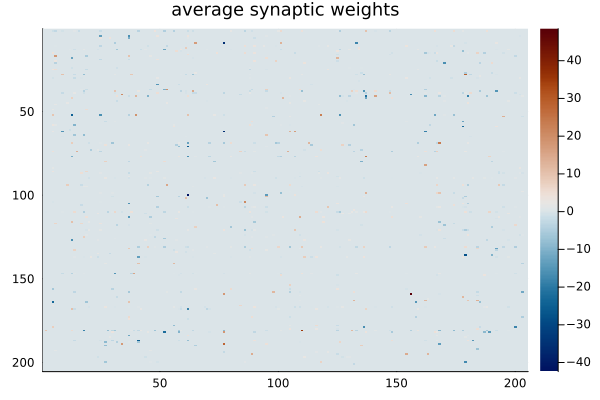

In [33]:
heatmap(A_10takes_avg, color=:vik50,yflip = true, title="average synaptic weights")

## Save average model weights (averaged across 30 datasets) using commented save filepath A_10takes_avg d_10takes_avg A_10takes 

In [34]:
using JLD2

data_folder = "data/model_weights"
filename = "avg_model_weights.jld2"
filepath = joinpath(joinpath(dir_one_up, data_folder), filename);

#######################################
###  average weights to save  #########
#######################################

#@save filepath A_10takes_avg d_10takes_avg A_10takes 
#@load "avg_model_weights.jld2" A_10takes_avg d_10takes_avg


"/Users/mmtre/Library/CloudStorage/OneDrive-IllinoisInstituteofTechnology/Github repos/Celegans_premotor/data/model_weights/avg_model_weights.jld2"